In [1]:
#pip install tensorflow-cpu
#pip install gymnasium
#pip install stable-baselines3
#pip install tensorflow-probability

#for project
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from gymnasium import Wrapper
import time

#stable-baselines3 (what isaac used, for consistency)
from stable_baselines3.common.monitor import Monitor
#from stable_baselines3.common.evaluation import evaluate_policy

#for gradient policy
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [4]:
#DONT RUN THIS SEGMENT
#the only change we made is to +100 for leg touching the ground (instead of the default +10)
class CustomRewardWrapper(Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        state, original_reward, truncated, terminated, info = self.env.step(action)
        reward = self.custom_reward(state, terminated or truncated, action, original_reward)
        return state, reward, truncated, terminated, info

    def custom_reward(self, state, is_terminal, action, original_reward):
        (_, _, _, _, _, _, leg_1_contact, leg_2_contact) = state

        reward = original_reward # maintain original rewards
        # Reward for leg contact
        if leg_1_contact:
            reward += 90 # default was +10
        if leg_2_contact:
            reward += 90 # default was +10

        return reward

def make_env():
    env = Monitor(gym.make("LunarLander-v2", render_mode="human"))
    env = CustomRewardWrapper(env)
    return env

## Task 1: Install gym, and play Lunar Lander with random control

In [4]:
#render_mode='human' lets us visualise the lander crashing :)
def make_env():
    return gym.make("LunarLander-v2", render_mode="human")

env = make_env()
#lets watch the lander crash 10 times :)
episodes = 10
for episode in range(episodes):
    step = 0
    state = env.reset()
    done = False
    score = 0
    while not done:
        step+=1
        env.render()
        action = env.action_space.sample()
        n_state,reward,done,info,_ = env.step(action)
        score+=reward
        #print('Episode:{} Step:{} Score:{}'.format(episode+1, step, score))  # Print the episode, step, and current score
    print('Episode:{} score:{}'.format(episode+1,score))
env.close()

Episode:1 score:-128.77960427635657
Episode:2 score:-95.49853092325836
Episode:3 score:-152.13199274873466
Episode:4 score:-114.3138774455485
Episode:5 score:-93.66948675806302
Episode:6 score:-203.62331605008237
Episode:7 score:-74.4202666475442
Episode:8 score:-324.1834415721117
Episode:9 score:-77.11662355441842
Episode:10 score:-343.6198393852065


## Task 2: Implementing Policy Gradient

In [2]:
#Policy Gradient seeks to approximate agent's policy (probability distribution over the action space given state)

#Policy Gradient Neural Network
class PolicyGradient(keras.Model):
    def __init__(self, num_actions, fc1num=256, fc2num=256):
        super(PolicyGradient,self).__init__()
        #Number of neurons for each fully connected layer
        self.fc1num = fc1num
        self.fc2num = fc2num
        self.num_actions = num_actions
        #Creating the fc1, fc2, fco (output) layers
        self.fc1 = Dense(self.fc1num, activation='relu')
        self.fc2 = Dense(self.fc2num, activation='relu')
        self.fco = Dense(self.num_actions, activation='softmax')
        
    def call(self, state):
        #Feedforward, outputs policy pi (probabilities)
        value = self.fc1(state)
        value = self.fc2(value)
        pi = self.fco(value)
        return pi
    
#Agent functions
class Agent:
    def __init__(self, lrate=0.001, gamma=0.99, num_actions=4, fc1num=256, fc2num=256):
        #lrate is the learning rate
        self.lr=lrate
        #gamma is the discount factor (from 0 to 1)
        self.gamma=gamma
        #4 default actions (nothing, left, down, right)
        self.num_actions=num_actions
        #3 memory arrays (cleared after every episode)
        self.state_memory=[]
        self.action_memory=[]
        self.reward_memory=[]
        #the policy gradient network
        self.policy=PolicyGradient(num_actions=num_actions, fc1num=fc1num, fc2num=fc2num)
        self.policy.compile(optimizer=Adam(learning_rate=self.lr))
        
    def choose_action(self,observation):
        state=tf.convert_to_tensor([observation],dtype=tf.float32)
        #sample random action based on the probability distribution
        probs=self.policy(state)
        action_probs=tfp.distributions.Categorical(probs=probs)
        action=action_probs.sample()
        return action.numpy()[0]
    
    def store_transition(self, observation,action,reward):
        #store transition info to memory arrays
        self.state_memory.append(observation)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        
    def learn(self):
        #convert the actions and rewards to tensorflow tensor
        actions=tf.convert_to_tensor(self.action_memory,dtype=tf.float32)
        rewards=np.array(self.reward_memory)
        #calculate G, the discounted sum of future rewards at each time step
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum=0
            discount=1
            for k in range(t,len(rewards)):
                G_sum+=rewards[k]*discount
                discount*=self.gamma
            G[t]=G_sum
        
        #calculate gradients wrt params of deep nn
        with tf.GradientTape() as tape:
            loss=0
            for idx,(g,state) in enumerate(zip(G,self.state_memory)):
                state=tf.convert_to_tensor([state],dtype=tf.float32)
                probs=self.policy(state)
                #clipping because we are taking the log (avoid log0)                              
                probs = tf.clip_by_value(probs, clip_value_min=1e-8, clip_value_max=1-1e-8)
                action_probs=tfp.distributions.Categorical(probs=probs)
                log_prob=action_probs.log_prob(actions[idx])
                loss += (-g)*tf.squeeze(log_prob)
                
        gradient=tape.gradient(loss,self.policy.trainable_variables)
        self.policy.optimizer.apply_gradients(zip(gradient,self.policy.trainable_variables))
        
        #reset memory (monte carlo method)
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

### Run 1: Default run (Learning rate 0.0003, fc_dim 256, time_threshold 40)

In [ ]:
#Note: i accidentally cleared the output for this cell. pls refer to "1defaultrun.txt" for a copy of the real output.

#hyperparams
lr0 = 0.0003
gamma0 = 0.99
episodes = 3000
fcdim = 256
time_threshold = 40

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]
for episode in range(episodes):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f}'.format(episode+1,score,ave_score,highsc))
    
    #evaluation after every 100 episodes
    if (episode+1)%100==0:
        print("Evaluation at episode {}".format(episode+1))
        for episode_e in range(10):
            start_time = time.time()
            state = env.reset()[0]
            done = False
            score = 0
            while not done:
                action = agent.choose_action(state)
                n_state,reward,done,info,_ = env.step(action)
                if time.time()-start_time>=time_threshold:
                    done=True
                    reward-=50
                agent.store_transition(observation=state,action=action,reward=reward)
                state=n_state
                score+=reward
            evalscores.append(score)
            print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
        ave_score = np.mean(evalscores[-10:])
        avgevalscores.append(ave_score)
        print('Evaluation at episode {}: average evaluation score:{}'.format(episode+1,ave_score))
        print('')

env.close()

In [7]:
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(6):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

Round:0 score:133.97356371410564
Round:1 score:-0.8326021871976224
Round:2 score:84.15829809128196
Round:3 score:-22.854554235383034
Round:4 score:163.43238488109824
Round:5 score:33.932770148297266


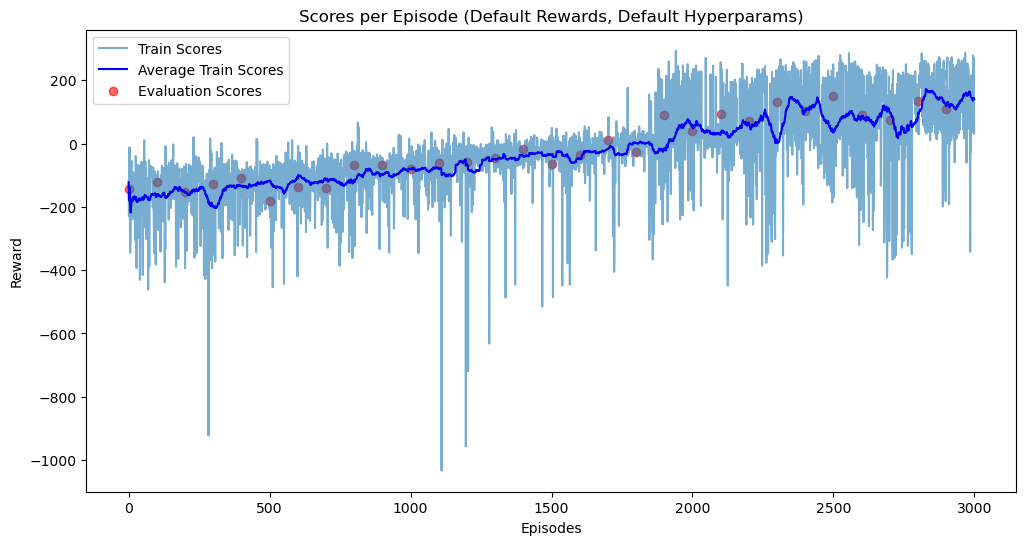

Highest score is at 1942 episodes with a score of 293.25250.
The first episode with score >= 200 is episode 1879 with score 235.70
Number of instances with score >= 200: 265


In [12]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(0, len(scores), 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Default Hyperparams)')
plt.legend()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))
    
#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [4]:
#Save the model
agent.policy.save_weights("1policygradient.h5")

#Load a model
#agent.policy.load_weights("1policygradient.h5")

### Run 2: Learning rate 0.0005 (fc_dim 256, time_threshold 40)

In [3]:
#hyperparams
lr0 = 0.0005
gamma0 = 0.99
episodes = 3000
fcdim = 256
time_threshold = 40

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]
for episode in range(episodes):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f}'.format(episode+1,score,ave_score,highsc))
    
    #evaluation after every 100 episodes
    if (episode+1)%100==0:
        print("\nEvaluation at episode {}".format(episode+1))
        for episode_e in range(10):
            start_time = time.time()
            state = env.reset()[0]
            done = False
            score = 0
            while not done:
                action = agent.choose_action(state)
                n_state,reward,done,info,_ = env.step(action)
                if time.time()-start_time>=time_threshold:
                    done=True
                    reward-=50
                agent.store_transition(observation=state,action=action,reward=reward)
                state=n_state
                score+=reward
            evalscores.append(score)
            print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
        ave_score = np.mean(evalscores[-10:])
        avgevalscores.append(ave_score)
        print('Evaluation at episode:{} average evaluation score:{}'.format(episode+1,ave_score))
        print('')

env.close()


Episode:1 score:-137.49 avgscore:-137.49 highscore:-137.49
Episode:2 score:-391.55 avgscore:-264.52 highscore:-137.49
Episode:3 score:-372.48 avgscore:-300.51 highscore:-137.49
Episode:4 score:-180.71 avgscore:-270.56 highscore:-137.49
Episode:5 score:-276.49 avgscore:-271.75 highscore:-137.49
Episode:6 score:-105.32 avgscore:-244.01 highscore:-105.32
Episode:7 score:-142.29 avgscore:-229.48 highscore:-105.32
Episode:8 score:-209.74 avgscore:-227.01 highscore:-105.32
Episode:9 score:-320.31 avgscore:-237.38 highscore:-105.32
Episode:10 score:-142.03 avgscore:-227.84 highscore:-105.32
Episode:11 score:-110.41 avgscore:-217.17 highscore:-105.32
Episode:12 score:-144.12 avgscore:-211.08 highscore:-105.32
Episode:13 score:-366.45 avgscore:-223.03 highscore:-105.32
Episode:14 score:-121.29 avgscore:-215.76 highscore:-105.32
Episode:15 score:-147.01 avgscore:-211.18 highscore:-105.32
Episode:16 score:-421.12 avgscore:-224.30 highscore:-105.32
Episode:17 score:-101.14 avgscore:-217.06 highsc

Episode:129 score:-106.97 avgscore:-148.75 highscore:18.43
Episode:130 score:-102.42 avgscore:-148.03 highscore:18.43
Episode:131 score:-134.16 avgscore:-148.93 highscore:18.43
Episode:132 score:-98.61 avgscore:-147.21 highscore:18.43
Episode:133 score:-267.41 avgscore:-149.45 highscore:18.43
Episode:134 score:-145.75 avgscore:-145.49 highscore:18.43
Episode:135 score:-92.68 avgscore:-144.76 highscore:18.43
Episode:136 score:-134.89 avgscore:-145.57 highscore:18.43
Episode:137 score:-151.85 avgscore:-146.61 highscore:18.43
Episode:138 score:-134.35 avgscore:-147.11 highscore:18.43
Episode:139 score:-54.36 avgscore:-146.30 highscore:18.43
Episode:140 score:-162.42 avgscore:-145.21 highscore:18.43
Episode:141 score:-88.29 avgscore:-144.73 highscore:18.43
Episode:142 score:-144.56 avgscore:-140.70 highscore:18.43
Episode:143 score:-141.98 avgscore:-141.75 highscore:18.43
Episode:144 score:-99.14 avgscore:-141.23 highscore:18.43
Episode:145 score:-71.98 avgscore:-139.95 highscore:18.43
Epi

Episode:259 score:-214.58 avgscore:-128.38 highscore:33.71
Episode:260 score:-207.26 avgscore:-126.87 highscore:33.71
Episode:261 score:-115.15 avgscore:-127.34 highscore:33.71
Episode:262 score:-106.75 avgscore:-126.58 highscore:33.71
Episode:263 score:-107.22 avgscore:-128.70 highscore:33.71
Episode:264 score:-236.30 avgscore:-130.45 highscore:33.71
Episode:265 score:-128.09 avgscore:-129.98 highscore:33.71
Episode:266 score:-136.78 avgscore:-129.84 highscore:33.71
Episode:267 score:29.16 avgscore:-124.04 highscore:33.71
Episode:268 score:-119.79 avgscore:-124.48 highscore:33.71
Episode:269 score:-229.33 avgscore:-126.24 highscore:33.71
Episode:270 score:-138.46 avgscore:-126.66 highscore:33.71
Episode:271 score:-100.23 avgscore:-126.68 highscore:33.71
Episode:272 score:-168.91 avgscore:-127.70 highscore:33.71
Episode:273 score:-129.27 avgscore:-127.48 highscore:33.71
Episode:274 score:-162.69 avgscore:-128.48 highscore:33.71
Episode:275 score:-221.23 avgscore:-129.39 highscore:33.71

Episode:389 score:-21.50 avgscore:-119.47 highscore:33.71
Episode:390 score:-132.74 avgscore:-120.71 highscore:33.71
Episode:391 score:-160.08 avgscore:-122.02 highscore:33.71
Episode:392 score:-146.15 avgscore:-123.34 highscore:33.71
Episode:393 score:-121.71 avgscore:-124.03 highscore:33.71
Episode:394 score:-68.35 avgscore:-123.05 highscore:33.71
Episode:395 score:-105.75 avgscore:-122.57 highscore:33.71
Episode:396 score:-85.25 avgscore:-122.41 highscore:33.71
Episode:397 score:-132.57 avgscore:-122.80 highscore:33.71
Episode:398 score:-139.75 avgscore:-122.83 highscore:33.71
Episode:399 score:-146.46 avgscore:-123.67 highscore:33.71
Episode:400 score:-83.03 avgscore:-122.61 highscore:33.71

Evaluation at episode 400
Evaluation Episode:1 score:-104.93913643239718
Evaluation Episode:2 score:-188.53107921741974
Evaluation Episode:3 score:-119.3935397719619
Evaluation Episode:4 score:-114.05985624494188
Evaluation Episode:5 score:-165.80337957832018
Evaluation Episode:6 score:-115.900

Episode:510 score:-303.40 avgscore:-107.29 highscore:33.71
Episode:511 score:-132.87 avgscore:-108.05 highscore:33.71
Episode:512 score:-109.26 avgscore:-108.57 highscore:33.71
Episode:513 score:-134.72 avgscore:-109.54 highscore:33.71
Episode:514 score:-289.79 avgscore:-113.46 highscore:33.71
Episode:515 score:-112.98 avgscore:-114.37 highscore:33.71
Episode:516 score:-139.59 avgscore:-115.97 highscore:33.71
Episode:517 score:-80.84 avgscore:-115.39 highscore:33.71
Episode:518 score:-124.72 avgscore:-115.15 highscore:33.71
Episode:519 score:-80.53 avgscore:-114.55 highscore:33.71
Episode:520 score:-111.67 avgscore:-114.30 highscore:33.71
Episode:521 score:-131.96 avgscore:-114.48 highscore:33.71
Episode:522 score:-194.17 avgscore:-116.75 highscore:33.71
Episode:523 score:-113.80 avgscore:-116.83 highscore:33.71
Episode:524 score:-115.83 avgscore:-116.82 highscore:33.71
Episode:525 score:-352.47 avgscore:-121.77 highscore:33.71
Episode:526 score:-126.31 avgscore:-122.08 highscore:33.71

Episode:641 score:-218.69 avgscore:-102.65 highscore:33.71
Episode:642 score:-153.34 avgscore:-104.05 highscore:33.71
Episode:643 score:-81.94 avgscore:-103.07 highscore:33.71
Episode:644 score:-87.86 avgscore:-100.90 highscore:33.71
Episode:645 score:-74.48 avgscore:-100.75 highscore:33.71
Episode:646 score:-82.89 avgscore:-99.96 highscore:33.71
Episode:647 score:-51.84 avgscore:-99.23 highscore:33.71
Episode:648 score:-51.01 avgscore:-98.33 highscore:33.71
Episode:649 score:-129.82 avgscore:-98.81 highscore:33.71
Episode:650 score:-36.42 avgscore:-97.49 highscore:33.71
Episode:651 score:-206.26 avgscore:-101.00 highscore:33.71
Episode:652 score:-253.47 avgscore:-104.89 highscore:33.71
Episode:653 score:-188.35 avgscore:-108.13 highscore:33.71
Episode:654 score:-97.74 avgscore:-108.17 highscore:33.71
Episode:655 score:-48.45 avgscore:-107.91 highscore:33.71
Episode:656 score:-46.59 avgscore:-106.58 highscore:33.71
Episode:657 score:-52.41 avgscore:-106.30 highscore:33.71
Episode:658 s

Episode:774 score:-26.87 avgscore:-76.24 highscore:33.71
Episode:775 score:4.15 avgscore:-74.40 highscore:33.71
Episode:776 score:-71.54 avgscore:-75.00 highscore:33.71
Episode:777 score:-49.05 avgscore:-74.42 highscore:33.71
Episode:778 score:-82.63 avgscore:-74.36 highscore:33.71
Episode:779 score:-42.11 avgscore:-73.74 highscore:33.71
Episode:780 score:-35.79 avgscore:-73.02 highscore:33.71
Episode:781 score:-75.09 avgscore:-72.23 highscore:33.71
Episode:782 score:-74.64 avgscore:-72.23 highscore:33.71
Episode:783 score:-42.78 avgscore:-71.59 highscore:33.71
Episode:784 score:-33.78 avgscore:-71.24 highscore:33.71
Episode:785 score:-70.30 avgscore:-70.21 highscore:33.71
Episode:786 score:-105.83 avgscore:-71.73 highscore:33.71
Episode:787 score:-52.10 avgscore:-71.87 highscore:33.71
Episode:788 score:-79.67 avgscore:-71.12 highscore:33.71
Episode:789 score:-41.04 avgscore:-70.77 highscore:33.71
Episode:790 score:-81.98 avgscore:-70.74 highscore:33.71
Episode:791 score:-42.35 avgscor

Evaluation Episode:9 score:-60.78131799224328
Evaluation Episode:10 score:-46.13313291246755
Evaluation at episode:900 average evaluation score:-66.33637245548309

Episode:901 score:-189.03 avgscore:-82.15 highscore:33.71
Episode:902 score:-67.79 avgscore:-79.84 highscore:33.71
Episode:903 score:-36.75 avgscore:-79.32 highscore:33.71
Episode:904 score:-144.27 avgscore:-81.27 highscore:33.71
Episode:905 score:-76.71 avgscore:-82.37 highscore:33.71
Episode:906 score:-12.25 avgscore:-80.92 highscore:33.71
Episode:907 score:-59.29 avgscore:-80.69 highscore:33.71
Episode:908 score:-158.46 avgscore:-81.72 highscore:33.71
Episode:909 score:-59.49 avgscore:-79.46 highscore:33.71
Episode:910 score:-46.41 avgscore:-79.07 highscore:33.71
Episode:911 score:-75.53 avgscore:-79.17 highscore:33.71
Episode:912 score:-38.38 avgscore:-78.23 highscore:33.71
Episode:913 score:-121.22 avgscore:-79.04 highscore:33.71
Episode:914 score:-64.33 avgscore:-78.88 highscore:33.71
Episode:915 score:-37.82 avgscore:

Episode:1032 score:-11.51 avgscore:-52.05 highscore:33.71
Episode:1033 score:-56.20 avgscore:-52.09 highscore:33.71
Episode:1034 score:-10.81 avgscore:-51.12 highscore:33.71
Episode:1035 score:-60.95 avgscore:-51.96 highscore:33.71
Episode:1036 score:-74.14 avgscore:-52.01 highscore:33.71
Episode:1037 score:-76.88 avgscore:-52.55 highscore:33.71
Episode:1038 score:-68.07 avgscore:-52.16 highscore:33.71
Episode:1039 score:-78.65 avgscore:-52.07 highscore:33.71
Episode:1040 score:-18.89 avgscore:-50.49 highscore:33.71
Episode:1041 score:-81.28 avgscore:-51.24 highscore:33.71
Episode:1042 score:-21.68 avgscore:-50.38 highscore:33.71
Episode:1043 score:-66.54 avgscore:-51.26 highscore:33.71
Episode:1044 score:-135.47 avgscore:-53.21 highscore:33.71
Episode:1045 score:-25.33 avgscore:-53.11 highscore:33.71
Episode:1046 score:-39.91 avgscore:-52.74 highscore:33.71
Episode:1047 score:-1.41 avgscore:-51.38 highscore:33.71
Episode:1048 score:-16.81 avgscore:-50.70 highscore:33.71
Episode:1049 s

Episode:1164 score:-71.35 avgscore:-73.17 highscore:39.70
Episode:1165 score:-44.10 avgscore:-73.92 highscore:39.70
Episode:1166 score:-81.77 avgscore:-74.82 highscore:39.70
Episode:1167 score:-57.15 avgscore:-75.47 highscore:39.70
Episode:1168 score:-34.64 avgscore:-73.55 highscore:39.70
Episode:1169 score:-152.07 avgscore:-72.31 highscore:39.70
Episode:1170 score:-117.88 avgscore:-74.67 highscore:39.70
Episode:1171 score:-12.56 avgscore:-72.87 highscore:39.70
Episode:1172 score:21.87 avgscore:-72.08 highscore:39.70
Episode:1173 score:-30.71 avgscore:-73.21 highscore:39.70
Episode:1174 score:-202.26 avgscore:-76.62 highscore:39.70
Episode:1175 score:39.95 avgscore:-74.53 highscore:39.95
Episode:1176 score:-29.45 avgscore:-74.42 highscore:39.95
Episode:1177 score:-21.97 avgscore:-74.03 highscore:39.95
Episode:1178 score:-87.21 avgscore:-72.80 highscore:39.95
Episode:1179 score:-35.17 avgscore:-72.14 highscore:39.95
Episode:1180 score:10.05 avgscore:-72.09 highscore:39.95
Episode:1181 s

Episode:1297 score:-23.87 avgscore:-31.32 highscore:42.99
Episode:1298 score:16.39 avgscore:-30.07 highscore:42.99
Episode:1299 score:5.21 avgscore:-29.60 highscore:42.99
Episode:1300 score:-37.11 avgscore:-29.46 highscore:42.99

Evaluation at episode 1300
Evaluation Episode:1 score:17.655815322316386
Evaluation Episode:2 score:31.919202363317424
Evaluation Episode:3 score:-35.82715155740446
Evaluation Episode:4 score:-208.78068576409672
Evaluation Episode:5 score:14.967194155722495
Evaluation Episode:6 score:-8.887966617744993
Evaluation Episode:7 score:-76.8802957501916
Evaluation Episode:8 score:13.159985090001612
Evaluation Episode:9 score:-48.69721402095932
Evaluation Episode:10 score:-30.338881232858185
Evaluation at episode:1300 average evaluation score:-33.17099980118974

Episode:1301 score:-72.74 avgscore:-30.54 highscore:42.99
Episode:1302 score:1.08 avgscore:-29.99 highscore:42.99
Episode:1303 score:-5.97 avgscore:-30.22 highscore:42.99
Episode:1304 score:-2.57 avgscore:-29.

Episode:1420 score:-29.38 avgscore:27.61 highscore:301.41
Episode:1421 score:-23.25 avgscore:28.25 highscore:301.41
Episode:1422 score:268.67 avgscore:34.22 highscore:301.41
Episode:1423 score:250.87 avgscore:34.47 highscore:301.41
Episode:1424 score:-17.14 avgscore:33.94 highscore:301.41
Episode:1425 score:-43.99 avgscore:29.04 highscore:301.41
Episode:1426 score:9.02 avgscore:29.28 highscore:301.41
Episode:1427 score:-32.43 avgscore:29.54 highscore:301.41
Episode:1428 score:25.15 avgscore:29.79 highscore:301.41
Episode:1429 score:-37.91 avgscore:30.23 highscore:301.41
Episode:1430 score:10.27 avgscore:29.93 highscore:301.41
Episode:1431 score:-12.68 avgscore:32.40 highscore:301.41
Episode:1432 score:-11.60 avgscore:31.85 highscore:301.41
Episode:1433 score:28.57 avgscore:34.76 highscore:301.41
Episode:1434 score:-24.02 avgscore:34.99 highscore:301.41
Episode:1435 score:-12.82 avgscore:35.68 highscore:301.41
Episode:1436 score:-17.86 avgscore:30.12 highscore:301.41
Episode:1437 score:

Episode:1555 score:16.46 avgscore:-0.28 highscore:301.41
Episode:1556 score:24.71 avgscore:-0.37 highscore:301.41
Episode:1557 score:-44.56 avgscore:-1.72 highscore:301.41
Episode:1558 score:2.04 avgscore:-1.75 highscore:301.41
Episode:1559 score:25.03 avgscore:-1.42 highscore:301.41
Episode:1560 score:49.12 avgscore:-0.52 highscore:301.41
Episode:1561 score:42.98 avgscore:0.78 highscore:301.41
Episode:1562 score:5.44 avgscore:1.46 highscore:301.41
Episode:1563 score:-3.80 avgscore:1.96 highscore:301.41
Episode:1564 score:-25.33 avgscore:3.21 highscore:301.41
Episode:1565 score:28.88 avgscore:3.46 highscore:301.41
Episode:1566 score:36.43 avgscore:4.69 highscore:301.41
Episode:1567 score:13.96 avgscore:5.10 highscore:301.41
Episode:1568 score:36.67 avgscore:5.84 highscore:301.41
Episode:1569 score:44.13 avgscore:7.71 highscore:301.41
Episode:1570 score:43.90 avgscore:9.20 highscore:301.41
Episode:1571 score:266.73 avgscore:15.04 highscore:301.41
Episode:1572 score:-28.96 avgscore:13.96

Episode:1689 score:306.45 avgscore:63.09 highscore:306.45
Episode:1690 score:214.71 avgscore:68.49 highscore:306.45
Episode:1691 score:254.25 avgscore:74.57 highscore:306.45
Episode:1692 score:238.63 avgscore:80.05 highscore:306.45
Episode:1693 score:264.68 avgscore:84.72 highscore:306.45
Episode:1694 score:283.13 avgscore:90.18 highscore:306.45
Episode:1695 score:234.83 avgscore:94.56 highscore:306.45
Episode:1696 score:223.20 avgscore:99.26 highscore:306.45
Episode:1697 score:65.13 avgscore:102.24 highscore:306.45
Episode:1698 score:261.09 avgscore:106.86 highscore:306.45
Episode:1699 score:23.10 avgscore:103.68 highscore:306.45
Episode:1700 score:12.85 avgscore:105.25 highscore:306.45

Evaluation at episode 1700
Evaluation Episode:1 score:240.4177875842945
Evaluation Episode:2 score:239.02359113978284
Evaluation Episode:3 score:254.4180716853036
Evaluation Episode:4 score:239.67208942381905
Evaluation Episode:5 score:-16.97810482036141
Evaluation Episode:6 score:249.44227498003093
E

Episode:1810 score:12.02 avgscore:131.37 highscore:306.45
Episode:1811 score:187.66 avgscore:132.51 highscore:306.45
Episode:1812 score:156.17 avgscore:130.21 highscore:306.45
Episode:1813 score:240.39 avgscore:134.82 highscore:306.45
Episode:1814 score:230.46 avgscore:134.22 highscore:306.45
Episode:1815 score:230.15 avgscore:133.55 highscore:306.45
Episode:1816 score:187.10 avgscore:137.61 highscore:306.45
Episode:1817 score:254.96 avgscore:142.82 highscore:306.45
Episode:1818 score:200.35 avgscore:145.76 highscore:306.45
Episode:1819 score:188.97 avgscore:148.68 highscore:306.45
Episode:1820 score:-233.56 avgscore:144.19 highscore:306.45
Episode:1821 score:33.71 avgscore:144.88 highscore:306.45
Episode:1822 score:245.36 avgscore:149.35 highscore:306.45
Episode:1823 score:2.35 avgscore:143.84 highscore:306.45
Episode:1824 score:-30.53 avgscore:138.28 highscore:306.45
Episode:1825 score:171.18 avgscore:141.06 highscore:306.45
Episode:1826 score:183.50 avgscore:139.44 highscore:306.45


Episode:1940 score:6.87 avgscore:107.82 highscore:306.45
Episode:1941 score:286.01 avgscore:109.04 highscore:306.45
Episode:1942 score:207.68 avgscore:108.37 highscore:306.45
Episode:1943 score:270.20 avgscore:113.30 highscore:306.45
Episode:1944 score:-106.93 avgscore:111.40 highscore:306.45
Episode:1945 score:236.04 avgscore:121.24 highscore:306.45
Episode:1946 score:265.99 avgscore:126.16 highscore:306.45
Episode:1947 score:286.56 avgscore:132.44 highscore:306.45
Episode:1948 score:255.89 avgscore:137.17 highscore:306.45
Episode:1949 score:2.95 avgscore:132.65 highscore:306.45
Episode:1950 score:41.09 avgscore:133.09 highscore:306.45
Episode:1951 score:260.63 avgscore:132.33 highscore:306.45
Episode:1952 score:54.14 avgscore:129.05 highscore:306.45
Episode:1953 score:219.05 avgscore:133.04 highscore:306.45
Episode:1954 score:-104.28 avgscore:132.07 highscore:306.45
Episode:1955 score:31.51 avgscore:133.30 highscore:306.45
Episode:1956 score:256.68 avgscore:134.26 highscore:306.45
Ep

Episode:2071 score:39.66 avgscore:146.10 highscore:306.45
Episode:2072 score:-54.80 avgscore:139.28 highscore:306.45
Episode:2073 score:-7.97 avgscore:135.75 highscore:306.45
Episode:2074 score:47.04 avgscore:132.27 highscore:306.45
Episode:2075 score:-9.60 avgscore:127.93 highscore:306.45
Episode:2076 score:40.88 avgscore:123.25 highscore:306.45
Episode:2077 score:13.66 avgscore:118.85 highscore:306.45
Episode:2078 score:39.92 avgscore:115.77 highscore:306.45
Episode:2079 score:310.29 avgscore:122.34 highscore:310.29
Episode:2080 score:7.44 avgscore:118.29 highscore:310.29
Episode:2081 score:272.76 avgscore:124.77 highscore:310.29
Episode:2082 score:13.21 avgscore:119.72 highscore:310.29
Episode:2083 score:273.53 avgscore:126.67 highscore:310.29
Episode:2084 score:268.04 avgscore:127.31 highscore:310.29
Episode:2085 score:-29.15 avgscore:122.38 highscore:310.29
Episode:2086 score:11.81 avgscore:118.40 highscore:310.29
Episode:2087 score:42.05 avgscore:115.05 highscore:310.29
Episode:2

Evaluation Episode:2 score:259.0853941949669
Evaluation Episode:3 score:229.24318227059058
Evaluation Episode:4 score:280.1895004651241
Evaluation Episode:5 score:269.2582161661781
Evaluation Episode:6 score:242.5979573994875
Evaluation Episode:7 score:56.36423295163107
Evaluation Episode:8 score:283.279968244898
Evaluation Episode:9 score:30.901374644499242
Evaluation Episode:10 score:-180.07620393801764
Evaluation at episode:2200 average evaluation score:172.0383743794694

Episode:2201 score:286.50 avgscore:166.58 highscore:310.29
Episode:2202 score:296.38 avgscore:174.09 highscore:310.29
Episode:2203 score:229.76 avgscore:178.85 highscore:310.29
Episode:2204 score:253.30 avgscore:178.68 highscore:310.29
Episode:2205 score:187.77 avgscore:182.28 highscore:310.29
Episode:2206 score:264.36 avgscore:181.48 highscore:310.29
Episode:2207 score:243.83 avgscore:181.07 highscore:310.29
Episode:2208 score:264.56 avgscore:181.21 highscore:310.29
Episode:2209 score:258.47 avgscore:181.20 highsc

Episode:2323 score:235.44 avgscore:118.12 highscore:313.23
Episode:2324 score:291.59 avgscore:119.38 highscore:313.23
Episode:2325 score:48.42 avgscore:115.63 highscore:313.23
Episode:2326 score:-9.68 avgscore:110.15 highscore:313.23
Episode:2327 score:288.54 avgscore:110.05 highscore:313.23
Episode:2328 score:231.08 avgscore:109.32 highscore:313.23
Episode:2329 score:245.15 avgscore:109.36 highscore:313.23
Episode:2330 score:-1.88 avgscore:103.40 highscore:313.23
Episode:2331 score:-30.65 avgscore:96.83 highscore:313.23
Episode:2332 score:-71.03 avgscore:96.09 highscore:313.23
Episode:2333 score:267.30 avgscore:95.98 highscore:313.23
Episode:2334 score:38.02 avgscore:91.28 highscore:313.23
Episode:2335 score:-89.23 avgscore:84.53 highscore:313.23
Episode:2336 score:-32.96 avgscore:84.58 highscore:313.23
Episode:2337 score:260.23 avgscore:85.99 highscore:313.23
Episode:2338 score:182.49 avgscore:90.46 highscore:313.23
Episode:2339 score:10.36 avgscore:91.73 highscore:313.23
Episode:234

Episode:2453 score:26.16 avgscore:180.90 highscore:322.94
Episode:2454 score:242.24 avgscore:188.89 highscore:322.94
Episode:2455 score:258.09 avgscore:191.29 highscore:322.94
Episode:2456 score:258.22 avgscore:192.59 highscore:322.94
Episode:2457 score:252.90 avgscore:193.78 highscore:322.94
Episode:2458 score:248.64 avgscore:199.20 highscore:322.94
Episode:2459 score:279.22 avgscore:199.57 highscore:322.94
Episode:2460 score:246.03 avgscore:200.18 highscore:322.94
Episode:2461 score:253.47 avgscore:201.82 highscore:322.94
Episode:2462 score:273.47 avgscore:202.22 highscore:322.94
Episode:2463 score:250.17 avgscore:201.87 highscore:322.94
Episode:2464 score:232.25 avgscore:201.28 highscore:322.94
Episode:2465 score:262.00 avgscore:210.77 highscore:322.94
Episode:2466 score:232.43 avgscore:211.37 highscore:322.94
Episode:2467 score:251.69 avgscore:217.00 highscore:322.94
Episode:2468 score:237.23 avgscore:217.09 highscore:322.94
Episode:2469 score:236.75 avgscore:216.77 highscore:322.9

Episode:2583 score:217.58 avgscore:244.75 highscore:322.94
Episode:2584 score:222.98 avgscore:244.05 highscore:322.94
Episode:2585 score:258.72 avgscore:244.01 highscore:322.94
Episode:2586 score:218.81 avgscore:243.19 highscore:322.94
Episode:2587 score:264.91 avgscore:242.87 highscore:322.94
Episode:2588 score:18.13 avgscore:238.23 highscore:322.94
Episode:2589 score:245.29 avgscore:236.92 highscore:322.94
Episode:2590 score:269.42 avgscore:237.22 highscore:322.94
Episode:2591 score:268.14 avgscore:237.50 highscore:322.94
Episode:2592 score:257.06 avgscore:237.95 highscore:322.94
Episode:2593 score:-94.52 avgscore:231.27 highscore:322.94
Episode:2594 score:19.09 avgscore:227.17 highscore:322.94
Episode:2595 score:259.13 avgscore:232.27 highscore:322.94
Episode:2596 score:231.67 avgscore:232.42 highscore:322.94
Episode:2597 score:267.04 avgscore:231.67 highscore:322.94
Episode:2598 score:213.84 avgscore:230.94 highscore:322.94
Episode:2599 score:203.59 avgscore:229.43 highscore:322.94

Episode:2703 score:257.36 avgscore:238.14 highscore:322.94
Episode:2704 score:218.13 avgscore:237.73 highscore:322.94
Episode:2705 score:242.49 avgscore:237.27 highscore:322.94
Episode:2706 score:267.21 avgscore:236.80 highscore:322.94
Episode:2707 score:256.65 avgscore:236.75 highscore:322.94
Episode:2708 score:177.71 avgscore:235.64 highscore:322.94
Episode:2709 score:255.08 avgscore:235.10 highscore:322.94
Episode:2710 score:228.89 avgscore:240.03 highscore:322.94
Episode:2711 score:279.28 avgscore:248.86 highscore:322.94
Episode:2712 score:248.73 avgscore:247.94 highscore:322.94
Episode:2713 score:256.18 avgscore:248.03 highscore:322.94
Episode:2714 score:239.05 avgscore:247.74 highscore:322.94
Episode:2715 score:274.94 avgscore:248.02 highscore:322.94
Episode:2716 score:237.24 avgscore:247.37 highscore:322.94
Episode:2717 score:235.17 avgscore:247.40 highscore:322.94
Episode:2718 score:250.08 avgscore:247.26 highscore:322.94
Episode:2719 score:244.58 avgscore:246.84 highscore:322.

Episode:2833 score:-63.50 avgscore:184.38 highscore:322.94
Episode:2834 score:180.05 avgscore:182.97 highscore:322.94
Episode:2835 score:-41.43 avgscore:176.29 highscore:322.94
Episode:2836 score:294.12 avgscore:177.06 highscore:322.94
Episode:2837 score:215.45 avgscore:175.65 highscore:322.94
Episode:2838 score:160.83 avgscore:172.90 highscore:322.94
Episode:2839 score:-110.20 avgscore:165.61 highscore:322.94
Episode:2840 score:200.34 avgscore:164.20 highscore:322.94
Episode:2841 score:-118.00 avgscore:159.93 highscore:322.94
Episode:2842 score:166.55 avgscore:163.55 highscore:322.94
Episode:2843 score:189.93 avgscore:162.83 highscore:322.94
Episode:2844 score:-61.26 avgscore:156.67 highscore:322.94
Episode:2845 score:165.65 avgscore:155.11 highscore:322.94
Episode:2846 score:-167.00 avgscore:147.25 highscore:322.94
Episode:2847 score:-103.67 avgscore:140.58 highscore:322.94
Episode:2848 score:189.75 avgscore:138.85 highscore:322.94
Episode:2849 score:238.96 avgscore:144.92 highscore:

Episode:2964 score:283.28 avgscore:198.09 highscore:322.94
Episode:2965 score:284.46 avgscore:199.69 highscore:322.94
Episode:2966 score:272.59 avgscore:199.58 highscore:322.94
Episode:2967 score:26.56 avgscore:195.74 highscore:322.94
Episode:2968 score:39.69 avgscore:192.51 highscore:322.94
Episode:2969 score:259.02 avgscore:200.29 highscore:322.94
Episode:2970 score:69.21 avgscore:197.58 highscore:322.94
Episode:2971 score:277.77 avgscore:198.44 highscore:322.94
Episode:2972 score:-2.60 avgscore:194.81 highscore:322.94
Episode:2973 score:37.58 avgscore:191.36 highscore:322.94
Episode:2974 score:47.51 avgscore:187.78 highscore:322.94
Episode:2975 score:15.57 avgscore:187.94 highscore:322.94
Episode:2976 score:39.10 avgscore:189.36 highscore:322.94
Episode:2977 score:0.82 avgscore:184.98 highscore:322.94
Episode:2978 score:35.86 avgscore:180.83 highscore:322.94
Episode:2979 score:57.03 avgscore:177.70 highscore:322.94
Episode:2980 score:16.38 avgscore:172.98 highscore:322.94
Episode:29

In [11]:
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

Round:0 score:225.93164273682333
Round:1 score:257.98209201205674
Round:2 score:229.07157118510662
Round:3 score:-35.71532360307374
Round:4 score:-40.70379758200127


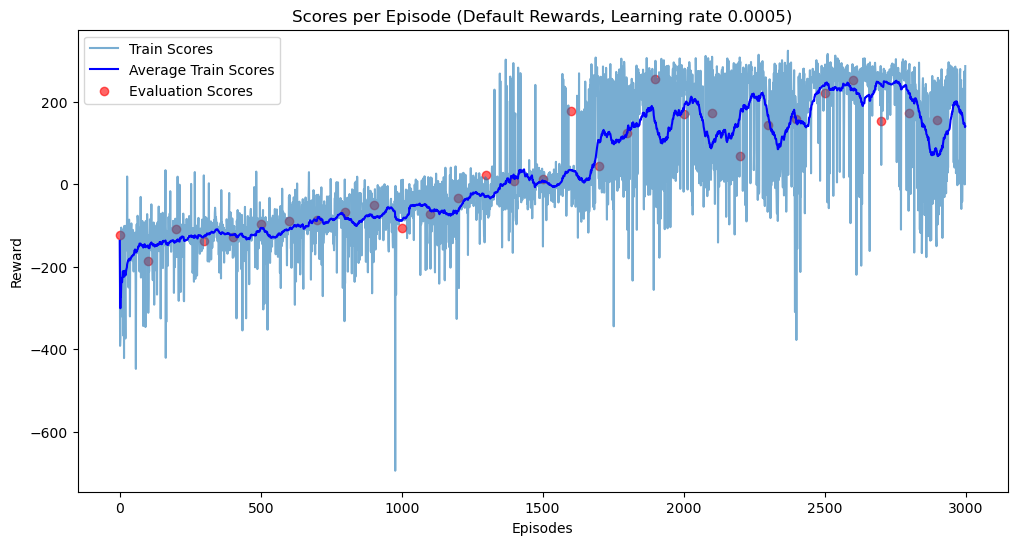

Highest score is at 2371 episodes with a score of 322.94107.
The first episode with score >= 200 is episode 1330 with score 228.73
Number of instances with score >= 200: 856


In [13]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(0, len(scores), 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0005)')
plt.legend()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [4]:
#Save the model
agent.policy.save_weights("2policygradient.h5")

#Load a model
#agent.policy.load_weights("2policygradient.h5")

### Run 3: Learning rate 0.0007 (fc_dim 256, time_threshold 40)

In [3]:
#on initial running, it is observed that the average scores peaked early and only decreased with further training, which
#could be a symptom of overfitting (specifically, the model learned to hover in place, or slowly moving away from the
#target even after landing, which significantly impacted scores).
#to mitigate this, we changed the experiment setting. We will be training the model in rounds of 100 episodes each time 
#followed by an evaluation run over 10 episodes. We will be artificially stopping the training when the training score/
#average training score/evaluation score has reached around the 200 point mark and is observed to decrease.
#this allows for more optimal training, given the circumstances. it also saves precious runtime (and reduce memory usage).
#we will also be using this approach for subsequent runs.

#hyperparams
lr0 = 0.0007
gamma0 = 0.99
episodes = 100
fcdim = 256
time_threshold=40

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
epis=-1
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]

In [18]:
#manually run this section of code repeatedly until avg scores peak (expected >=200)
for episode in range(episodes):
    epis+=1
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f} time:{:.2f}'.format(epis+1,score,ave_score,highsc,time.time()-start_time))


#evaluation after every 100 episodes
print("\nEvaluation at episode {}".format(epis+1))
for episode_e in range(10):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    evalscores.append(score)
    print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
ave_score = np.mean(evalscores[-10:])
avgevalscores.append(ave_score)
print('Evaluation at episode:{} average evaluation score:{}'.format(epis+1,ave_score))
print('')

Episode:1301 score:236.40 avgscore:192.40 highscore:287.19 time:26.42
Episode:1302 score:-10.56 avgscore:188.15 highscore:287.19 time:1.87
Episode:1303 score:244.78 avgscore:189.50 highscore:287.19 time:3.40
Episode:1304 score:188.53 avgscore:190.04 highscore:287.19 time:6.03
Episode:1305 score:209.63 avgscore:190.04 highscore:287.19 time:5.41
Episode:1306 score:205.13 avgscore:190.06 highscore:287.19 time:4.78
Episode:1307 score:204.09 avgscore:190.54 highscore:287.19 time:4.54
Episode:1308 score:173.94 avgscore:191.02 highscore:287.19 time:5.81
Episode:1309 score:176.70 avgscore:190.22 highscore:287.19 time:4.89
Episode:1310 score:161.69 avgscore:189.30 highscore:287.19 time:7.34
Episode:1311 score:-40.98 avgscore:185.02 highscore:287.19 time:3.12
Episode:1312 score:146.88 avgscore:183.84 highscore:287.19 time:5.63
Episode:1313 score:232.70 avgscore:184.56 highscore:287.19 time:4.21
Episode:1314 score:245.71 avgscore:185.44 highscore:287.19 time:3.67
Episode:1315 score:196.78 avgscor

In [24]:
env.close()
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

Round:0 score:234.01072047566882
Round:1 score:242.7868768739389
Round:2 score:290.27647677676305
Round:3 score:-33.7905341791551
Round:4 score:295.98999157960236


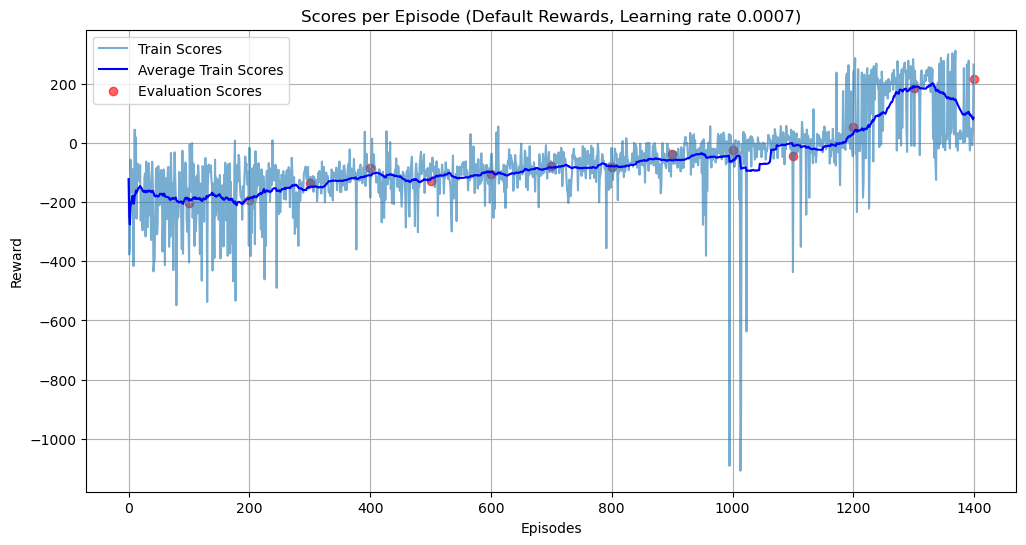

Highest score is at 1370 episodes with a score of 312.06198.
The first episode with score >= 200 is episode 1173 with score 237.93
Number of instances with score >= 200: 102


In [28]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(100, len(scores)+100, 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0007)')
plt.legend()
plt.grid()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [25]:
#Save the model
agent.policy.save_weights("3policygradient.h5")

#Load a model
#agent.policy.load_weights("3policygradient.h5")

### Run 4: fc_dim 128 (Learning rate 0.0005, time_threshold 40)

In [3]:
#new format from run 3

#hyperparams
lr0 = 0.0005
gamma0 = 0.99
episodes = 100
fcdim = 128
time_threshold=40

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
epis=-1
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]

In [23]:
#manually run this section of code repeatedly until avg scores peak (expected >=200)
for episode in range(episodes):
    epis+=1
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f} time:{:.2f}'.format(epis+1,score,ave_score,highsc,time.time()-start_time))


#evaluation after every 100 episodes
print("\nEvaluation at episode {}".format(epis+1))
for episode_e in range(10):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    evalscores.append(score)
    print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
ave_score = np.mean(evalscores[-10:])
avgevalscores.append(ave_score)
print('Evaluation at episode {} average evaluation score:{}'.format(epis+1,ave_score))
print('')

Episode:1801 score:21.75 avgscore:136.33 highscore:311.35 time:25.32
Episode:1802 score:270.96 avgscore:142.67 highscore:311.35 time:3.26
Episode:1803 score:166.84 avgscore:142.14 highscore:311.35 time:4.68
Episode:1804 score:276.50 avgscore:143.37 highscore:311.35 time:3.65
Episode:1805 score:281.35 avgscore:149.02 highscore:311.35 time:4.47
Episode:1806 score:249.07 avgscore:148.51 highscore:311.35 time:3.41
Episode:1807 score:230.17 avgscore:152.20 highscore:311.35 time:2.58
Episode:1808 score:269.93 avgscore:157.18 highscore:311.35 time:3.05
Episode:1809 score:28.62 avgscore:157.73 highscore:311.35 time:1.85
Episode:1810 score:245.99 avgscore:158.20 highscore:311.35 time:4.50
Episode:1811 score:264.62 avgscore:159.23 highscore:311.35 time:3.05
Episode:1812 score:14.20 avgscore:155.23 highscore:311.35 time:2.18
Episode:1813 score:222.29 avgscore:155.70 highscore:311.35 time:4.33
Episode:1814 score:-135.50 avgscore:153.38 highscore:311.35 time:3.33
Episode:1815 score:271.26 avgscore:

In [27]:
env.close()
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

Round:0 score:262.6654578819989
Round:1 score:243.42798077066104
Round:2 score:279.6200194589402
Round:3 score:233.10081237508894
Round:4 score:279.8625028588133


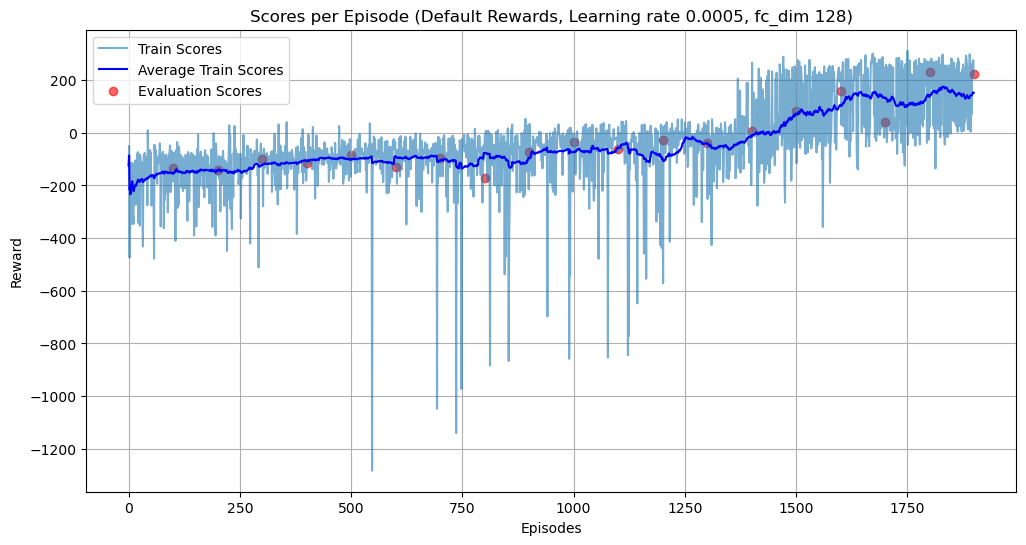

Highest score is at 1751 episodes with a score of 311.35346.
The first episode with score >= 200 is episode 1370 with score 205.17
Number of instances with score >= 200: 205


In [28]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(100, len(scores)+100, 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0005, fc_dim 128)')
plt.legend()
plt.grid()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [24]:
#Save the model
agent.policy.save_weights("4policygradient.h5")

#Load a model
#agent.policy.load_weights("4policygradient.h5")

### Run 5: fc_dim 64 (Learning rate 0.0005, time_threshold 40)

In [ ]:
#new format from run 3

#hyperparams
lr0 = 0.0005
gamma0 = 0.99
episodes = 100
fcdim = 64
time_threshold=40

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
epis=-1
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]

In [ ]:
#manually run this section of code repeatedly until avg scores peak (expected >=200)
for episode in range(episodes):
    epis+=1
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f} time:{:.2f}'.format(epis+1,score,ave_score,highsc,time.time()-start_time))


#evaluation after every 100 episodes
print("\nEvaluation at episode {}".format(epis+1))
for episode_e in range(10):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    evalscores.append(score)
    print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
ave_score = np.mean(evalscores[-10:])
avgevalscores.append(ave_score)
print('Evaluation at episode {} average evaluation score:{}'.format(epis+1,ave_score))
print('')

In [7]:
#export the printed details
%%capture cap --no-stderr
with open('5fcdim512run.txt', 'w') as f:
    f.write(cap.stdout)

In [1]:
env.close()
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

NameError: name 'gym' is not defined

In [ ]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(100, len(scores)+100, 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0005, fc_dim 64)')
plt.legend()
plt.grid()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [ ]:
#Save the model
agent.policy.save_weights("5policygradient.h5")

#Load a model
#agent.policy.load_weights("5policygradient.h5")

### Run 6: time_threshold 30 (Learning rate 0.0005, fc_dim 256)

In [ ]:
#new format from run 3

#hyperparams
lr0 = 0.0005
gamma0 = 0.99
episodes = 100
fcdim = 256
time_threshold=30

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
epis=-1
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]

In [ ]:
#manually run this section of code repeatedly until avg scores peak (expected >=200)
for episode in range(episodes):
    epis+=1
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f} time:{:.2f}'.format(epis+1,score,ave_score,highsc,time.time()-start_time))


#evaluation after every 100 episodes
print("\nEvaluation at episode {}".format(epis+1))
for episode_e in range(10):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    evalscores.append(score)
    print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
ave_score = np.mean(evalscores[-10:])
avgevalscores.append(ave_score)
print('Evaluation at episode {} average evaluation score:{}'.format(epis+1,ave_score))
print('')

In [7]:
#export the printed details
%%capture cap --no-stderr
with open('6timethreshold30run.txt', 'w') as f:
    f.write(cap.stdout)

In [1]:
env.close()
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

NameError: name 'gym' is not defined

In [ ]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(100, len(scores)+100, 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0005, time_threshold 30)')
plt.legend()
plt.grid()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [ ]:
#Save the model
agent.policy.save_weights("6policygradient.h5")

#Load a model
#agent.policy.load_weights("6policygradient.h5")

### Run 7: time_threshold 20 (Learning rate 0.0005, fc_dim 256)

In [ ]:
#new format from run 3

#hyperparams
lr0 = 0.0005
gamma0 = 0.99
episodes = 100
fcdim = 256
time_threshold=20

agent=Agent(lrate=lr0,gamma=gamma0,num_actions=4, fc1num=fcdim, fc2num=fcdim)
env=gym.make("LunarLander-v2")
epis=-1
scores=[]
highsc=-1000
avgscores=[]
evalscores=[]
avgevalscores=[]

In [ ]:
#manually run this section of code repeatedly until avg scores peak (expected >=200)
for episode in range(episodes):
    epis+=1
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    if score>highsc:
        highsc=score
    scores.append(score)
    agent.learn()
    ave_score = np.mean(scores[-50:])
    avgscores.append(ave_score)
    print('Episode:{} score:{:.2f} avgscore:{:.2f} highscore:{:.2f} time:{:.2f}'.format(epis+1,score,ave_score,highsc,time.time()-start_time))


#evaluation after every 100 episodes
print("\nEvaluation at episode {}".format(epis+1))
for episode_e in range(10):
    start_time = time.time()
    state = env.reset()[0]
    done = False
    score = 0
    while not done:
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
            reward-=50
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    evalscores.append(score)
    print('Evaluation Episode:{} score:{}'.format(episode_e+1,score))
ave_score = np.mean(evalscores[-10:])
avgevalscores.append(ave_score)
print('Evaluation at episode {} average evaluation score:{}'.format(epis+1,ave_score))
print('')

In [7]:
#export the printed details
%%capture cap --no-stderr
with open('7timethreshold20run.txt', 'w') as f:
    f.write(cap.stdout)

In [1]:
env.close()
#VIDEO RECORD: Testing model success (out of 5 runs)
env=gym.make("LunarLander-v2", render_mode="human")
time_threshold = 40
for episode in range(5):
    start_time = time.time()
    score=0
    state = env.reset()[0]
    done = False
    while not done:
        env.render()
        action = agent.choose_action(state)
        n_state,reward,done,info,_ = env.step(action)
        if time.time()-start_time>=time_threshold:
            done=True
        agent.store_transition(observation=state,action=action,reward=reward)
        state=n_state
        score+=reward
    print('Round:{} score:{}'.format(episode,score))
env.close()

NameError: name 'gym' is not defined

In [ ]:
plt.figure(figsize=(12, 6))

#plot individual scores
plt.plot(range(len(scores)), scores, label='Train Scores', alpha=0.6)
plt.plot(range(len(scores)), avgscores, color='b', label='Average Train Scores')

# Plot evaluation rewards
# Use scatter for evaluation to distinguish it from training
plt.scatter(range(100, len(scores)+100, 100), avgevalscores, color='red', label='Evaluation Scores', alpha=0.6)

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Scores per Episode (Default Rewards, Learning rate 0.0005, time_threshold 20)')
plt.legend()
plt.grid()
plt.show()

#finding the highest reward
print("Highest score is at %d episodes with a score of %.5f." %(scores.index(max(scores))+1, max(scores)))
if max(scores)>=200:
    for i in range(len(scores)):
        if scores[i] >= 200:
            break
    print("The first episode with score >= 200 is episode {} with score {:.2f}".format(i+1,scores[i]))

#find the number of success cases
print(f'Number of instances with score >= 200: {sum(1 for num in scores if num >= 200)}')

In [ ]:
#Save the model
agent.policy.save_weights("7policygradient.h5")

#Load a model
#agent.policy.load_weights("7policygradient.h5")